# Camera calibration using CHARUCO

In [1]:
import numpy as np
import cv2, PIL, os
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib nbagg


## 2. Camera pose estimation using CHARUCO chessboard

First, let's create the board.

<IPython.core.display.Javascript object>


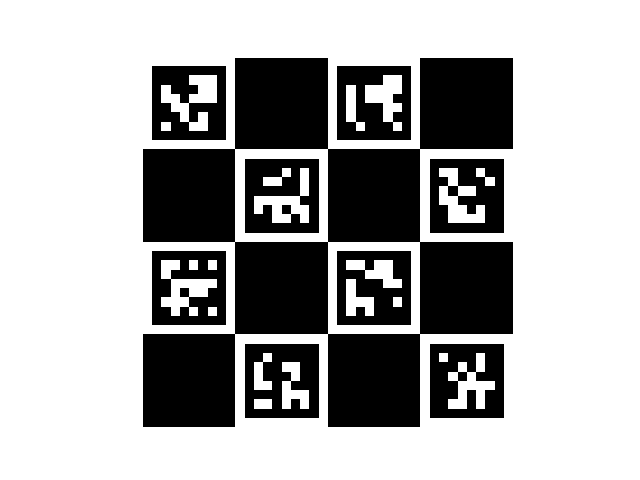

In [101]:
imageDir = "images/"
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
board = aruco.CharucoBoard_create(4, 4, 0.01, 0.008, aruco_dict)
imboard = board.draw((2000, 2000))
cv2.imwrite(imageDir + "chessboard.tiff", imboard)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
ax.axis("off")
plt.show()


And take photos of it from multiple angles, for example:

In [102]:
datadir = "images/camCal/"
# images = np.array([datadir + f for f in os.listdir(datadir) if f.endswith(".png") ])
images = np.array([datadir + f for f in os.listdir(datadir) if f.endswith(".jpg") ])
order = np.argsort([int(p.split(".")[-2].split("_")[-1]) for p in images])
images = images[order]
images

array(['images/camCal/IMG_20200416_214556_1.jpg',
       'images/camCal/IMG_20200416_214742_1.jpg',
       'images/camCal/IMG_20200416_214746_1.jpg',
       'images/camCal/IMG_20200416_214810.jpg',
       'images/camCal/IMG_20200416_215129.jpg',
       'images/camCal/IMG_20200416_215233.jpg',
       'images/camCal/IMG_20200416_215240.jpg',
       'images/camCal/IMG_20200416_215307.jpg',
       'images/camCal/IMG_20200416_215513.jpg',
       'images/camCal/IMG_20200416_215610.jpg'], dtype='<U39')

<IPython.core.display.Javascript object>


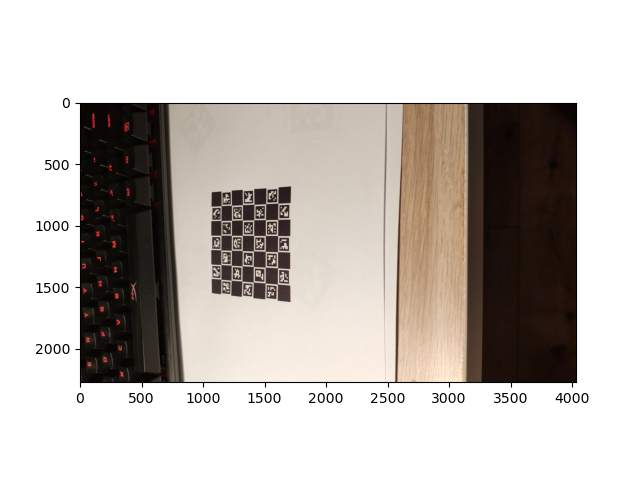

In [103]:
im = PIL.Image.open(images[0])
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(im)
#ax.axis('off')
plt.show()

Now, the camera calibration can be done using all the images of the chessboard. Two functions are necessary:

* The first will detect markers on all the images and.
* The second will proceed the detected markers to estimage the camera calibration data.

In [104]:
def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0
    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

    for im in images:
        print("=> Processing image {0}".format(im))
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
        
        if len(corners)>0:
            # SUB PIXEL DETECTION
            for corner in corners:
                cv2.cornerSubPix(gray, corner, 
                                 winSize = (3,3), 
                                 zeroZone = (-1,-1), 
                                 criteria = criteria)
            res2 = cv2.aruco.interpolateCornersCharuco(corners,ids,gray,board)        
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])              
        
        decimator+=1   

    imsize = gray.shape
    return allCorners,allIds,imsize

In [105]:
allCorners,allIds,imsize=read_chessboards(images)

POSE ESTIMATION STARTS:
=> Processing image images/camCal/IMG_20200416_214556_1.jpg
=> Processing image images/camCal/IMG_20200416_214742_1.jpg
=> Processing image images/camCal/IMG_20200416_214746_1.jpg
=> Processing image images/camCal/IMG_20200416_214810.jpg
=> Processing image images/camCal/IMG_20200416_215129.jpg
=> Processing image images/camCal/IMG_20200416_215233.jpg
=> Processing image images/camCal/IMG_20200416_215240.jpg
=> Processing image images/camCal/IMG_20200416_215307.jpg
=> Processing image images/camCal/IMG_20200416_215513.jpg
=> Processing image images/camCal/IMG_20200416_215610.jpg


In [106]:
def calibrate_camera(allCorners,allIds,imsize):   
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")
    
    cameraMatrixInit = np.array([[ 1000.,    0., imsize[0]/2.],
                                 [    0., 1000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
#     flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO) 
#     flags = (cv2.CALIB_RATIONAL_MODEL) 
#     (ret, camera_matrix, distortion_coefficients0, 
#      rotation_vectors, translation_vectors,
#      stdDeviationsIntrinsics, stdDeviationsExtrinsics, 
#      perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
#                       charucoCorners=allCorners,
#                       charucoIds=allIds,
#                       board=board,
#                       imageSize=imsize,
#                       cameraMatrix=cameraMatrixInit,
#                       distCoeffs=distCoeffsInit,
#                       flags=flags,
#                       criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))
    (ret, camera_matrix, distortion_coefficients0, 
     rotation_vectors, translation_vectors) = cv2.aruco.calibrateCameraCharuco(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix = None,
                      distCoeffs = None)

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

In [107]:
%time ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)

CAMERA CALIBRATION
Wall time: 20 ms


In [108]:
ret

59.0899997179076

In [109]:
mtx

array([[1.64243279e+03, 0.00000000e+00, 4.20232735e+03],
       [0.00000000e+00, 8.23992366e+02, 2.04541932e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [110]:
dist

array([[ 0.23599706,  0.01765483, -0.00760653,  0.01567332, -0.02030943]])

In [111]:
np.savetxt("camCalMtx.csv", mtx)
np.savetxt("camCalDist.csv", dist)


### Check calibration results

<IPython.core.display.Javascript object>


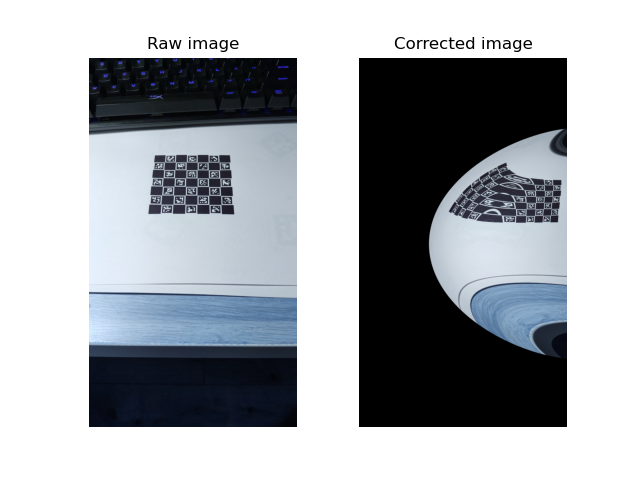

In [112]:
i=0 # select image id
plt.figure()
# frame = cv2.imread(images[i])
testFilePath = "images/camCal/IMG_20200416_214556_1.jpg"
# testFilePath = "images/pos1.jpg"
frame = cv2.imread(testFilePath)
img_undist = cv2.undistort(frame,mtx,dist,None)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")
plt.show()

## 3 . Use of camera calibration to estimate 3D translation and rotation of each marker on a scene

<IPython.core.display.Javascript object>


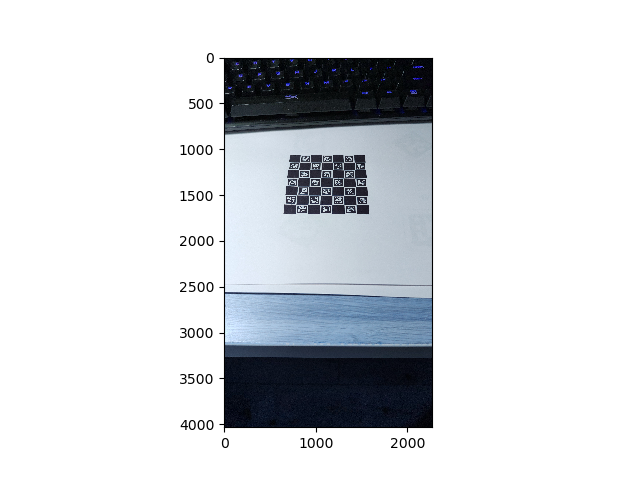

In [113]:

frame = cv2.imread("images/pos1.jpg")
frame = cv2.imread(testFilePath)
#frame = cv2.undistort(src = frame, cameraMatrix = mtx, distCoeffs = dist)
plt.figure()
plt.imshow(frame, interpolation = "nearest")
plt.show()

## Post processing

In [115]:

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, 
                                                      parameters=parameters)
# SUB PIXEL DETECTION
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
for corner in corners:
    cv2.cornerSubPix(gray, corner, winSize = (3,3), zeroZone = (-1,-1), criteria = criteria)
    
frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

corners

[array([[[1561.3988, 1603.0123],
         [1456.2876, 1601.7501],
         [1452.9508, 1523.5131],
         [1555.8953, 1525.2966]]], dtype=float32),
 array([[[1410.3158, 1142.8142],
         [1315.7957, 1142.4031],
         [1314.0056, 1076.478 ],
         [1407.7803, 1077.5889]]], dtype=float32),
 array([[[1434.01  , 1701.5994],
         [1328.0226, 1699.7207],
         [1325.8113, 1621.3082],
         [1430.6779, 1622.0474]]], dtype=float32),
 array([[[1167.3711, 1698.7772],
         [1061.7291, 1698.3556],
         [1063.9158, 1619.2677],
         [1168.2397, 1620.776 ]]], dtype=float32),
 array([[[ 902.2765 , 1697.6583 ],
         [ 795.0339 , 1698.3224 ],
         [ 801.6324 , 1619.2484 ],
         [ 907.37494, 1619.6843 ]]], dtype=float32),
 array([[[ 777.4742 , 1597.5579 ],
         [ 671.93994, 1595.7095 ],
         [ 680.3782 , 1516.0491 ],
         [ 784.1938 , 1518.5107 ]]], dtype=float32),
 array([[[1548.298 , 1405.7965],
         [1447.4241, 1407.5607],
         [1444.082

Very fast processing !

## Results

<IPython.core.display.Javascript object>


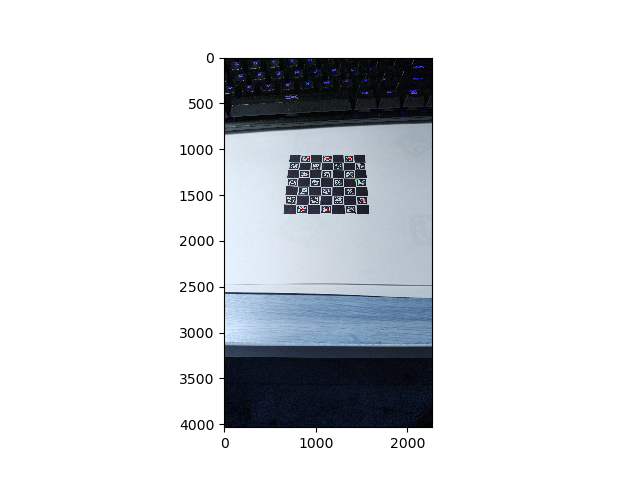

In [116]:
plt.figure()
plt.imshow(frame_markers, interpolation = "nearest")

plt.show()

### Add local axis on each marker

In [117]:
size_of_marker =  0.03 # side lenght of the marker in meter
rvecs,tvecs,trash = aruco.estimatePoseSingleMarkers(corners, size_of_marker , mtx, dist)

In [118]:
refID = 1
checkID = 3
if refID in ids:
    idx = np.where(ids == refID)
    rRefMtx,_jacob = cv2.Rodrigues(rvecs[idx])
    tRefVec = tvecs[idx][0]
for i in range(len(rvecs)):
    markerID = ids[i,0]
    rMtx,_jacob = cv2.Rodrigues(rvecs[i])
    tVec = tvecs[i][0]
    if markerID == checkID:
        print('------  ID = {0} ------'.format(markerID))
        print('Transition')
        print(1000*rRefMtx.T@(tVec-tRefVec))
        print('Rotation')
        print(rRefMtx.T@rMtx)
        print('Diatance')
        print (1000*np.linalg.norm(rRefMtx.T@(tVec-tRefVec)))
        print('Angle')
        print(np.rad2deg(np.arctan((rRefMtx.T@rMtx)[1,0]/(rRefMtx.T@rMtx)[0,0])))
        

------  ID = 3 ------
Transition
[ -69.19299442 -153.80376553 -406.23121025]
Rotation
[[ 0.25725148 -0.10414759  0.96071586]
 [-0.09799504  0.98623872  0.13315462]
 [-0.96136291 -0.12839962  0.24350543]]
Diatance
439.84891150244954
Angle
-20.85338438784008


In [119]:
length_of_axis = 0.015
imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

for i in range(len(tvecs)):
    imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)

<IPython.core.display.Javascript object>


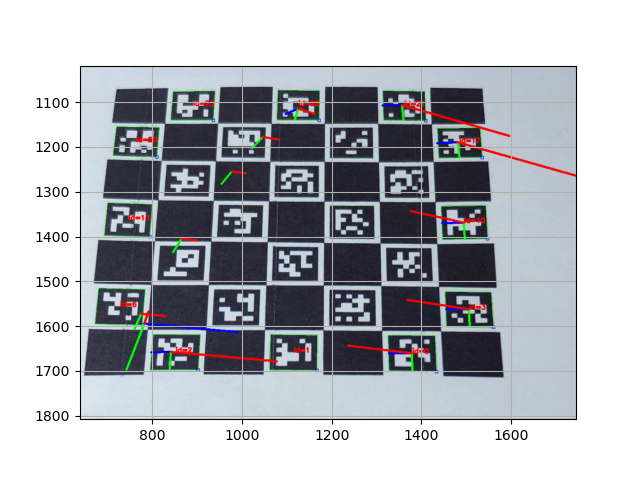

In [120]:
plt.figure()
plt.imshow(imaxis)
plt.grid()
plt.show()

In [34]:
data = pd.DataFrame(data = tvecs.reshape(len(tvecs),3), columns = ["tx", "ty", "tz"], 
                    index = ids.flatten())
data.index.name = "marker"
data.sort_index(inplace= True)
data

,tx,ty,tz
marker,,,
0,-0.169486,-0.097014,0.300808
1,-0.070766,-0.118239,0.299219
2,0.028443,-0.120922,0.305648
3,-0.070694,-0.016792,0.299402
4,0.028606,-0.017873,0.303441


In [35]:
datar = pd.DataFrame(data = tvecs.reshape(len(rvecs),3), columns = ["rx", "ry", "rz"], 
                    index = ids.flatten())
datar.index.name = "marker"
datar.sort_index(inplace= True)
np.degrees(datar)


,rx,ry,rz
marker,,,
0,-9.710852,-5.558496,17.235030
1,-4.054575,-6.774616,17.144009
2,1.629649,-6.928336,17.512350
3,-4.050471,-0.962110,17.154450
4,1.639025,-1.024058,17.385863


In [36]:
v = data.loc[3:6].values
((v[1:] - v[:-1])**2).sum(axis = 1)**.5

array([0.09938843])

In [37]:
cv2.Rodrigues(rvecs[0], np.zeros((3,3)))

(array([[-0.00828757, -0.99820317,  0.05934425],
        [-0.99869638,  0.01125167,  0.04978896],
        [-0.05036722, -0.05885425, -0.99699515]]),
 array([[-0.43562411,  0.03399224,  0.51093244,  0.02939719,  0.48993692,
          0.47894664, -0.5112174 , -0.48286324,  0.05433041],
        [-0.48622949, -0.02526442, -0.49286477, -0.02062419,  0.43138265,
         -0.51117908,  0.48894817,  0.51097076, -0.05486463],
        [ 0.00218584, -0.02714155, -0.45623069,  0.02322495,  0.00222416,
          0.46535711, -0.46087093,  0.46076206, -0.00391679]]))

<IPython.core.display.Javascript object>


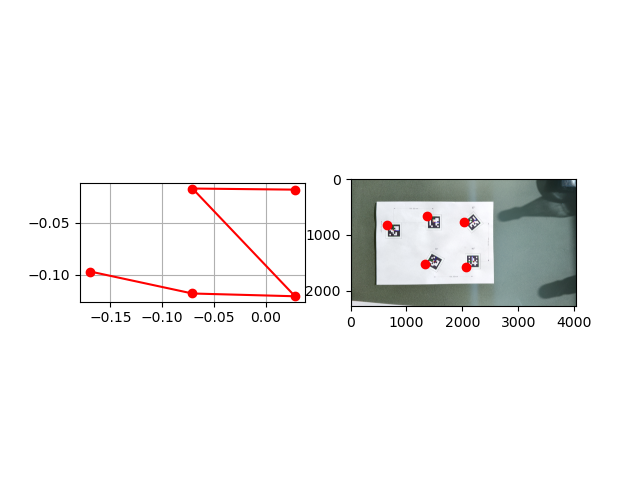

In [38]:
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(1,2,1)
ax.set_aspect("equal")
plt.plot(data.tx, data.ty, "or-")
plt.grid()
ax = fig.add_subplot(1,2,2)
plt.imshow(imaxis, origin = "upper")
plt.plot(np.array(corners)[:, 0, 0,0], np.array(corners)[:, 0, 0,1], "or")
plt.show()

In [39]:
a = np.arange(50)
a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [40]:
import pickle

In [41]:
f = open("truc.pckl", "wb")
pickle.dump(a, f)
f.close()

In [42]:
f = open("truc.pckl", "rb")
b = pickle.load(f)
b == a

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [43]:
corners = np.array(corners)
data2 = pd.DataFrame({"px": corners[:, 0, 0, 1], 
                      "py": corners[:, 0, 0, 0]}, index = ids.flatten())
data2.sort_index(inplace=True)
data2

,px,py
0,814.680542,657.162292
1,667.230591,1369.689453
2,763.506653,2024.436157
3,1518.754272,1333.503174
4,1574.066162,2070.215088


In [44]:
m0 = data2.loc[0]
m43 = data2.loc[43]
d01 = ((m0 - m43).values**2).sum()**.5
d = 42.5e-3 * (3.5**2 + 4.5**2)**.5
factor = d / d01
data2["x"] = data2.px * factor
data2["y"] = data2.py * factor
((data2[["x", "y"]].loc[11] - data2[["x", "y"]].loc[0]).values**2).sum()**.5


KeyError: 43

In [347]:

c = np.array(corners).astype(np.float64).reshape(44,4,2)
(((c[:, 1:] - c[:, :-1])**2).sum(axis = 2)**.5).mean(axis =1)

array([ 138.33575835,  143.00113377,  142.012097  ,  140.69699432,
        146.66782406,  144.02442319,  138.67845434,  142.33812925,
        143.00229095,  140.33926025,  140.35356753,  146.66786569,
        139.34054504,  146.67222201,  140.03570454,  148.01939184,
        143.35647769,  142.67236143,  147.01931296,  148.02127735,
        137.67392157,  135.35308209,  141.00354688,  143.67946992,
        137.67149733,  138.67392207,  145.00112611,  142.33454105,
        138.3466791 ,  143.00234925,  139.0035972 ,  143.00115739,
        143.6865917 ,  144.67964727,  144.33446711,  141.67253496,
        143.67117097,  147.67232772,  150.35663387,  141.70034559,
        149.01342342,  146.01949591,  144.34013329,  150.35333222])

In [343]:
c

array([[[ 2406.,  1940.],
        [ 2546.,  1940.],
        [ 2545.,  2075.],
        [ 2405.,  2076.]],

       [[ 1991.,  1938.],
        [ 2138.,  1939.],
        [ 2138.,  2076.],
        [ 1993.,  2076.]],

       [[ 1584.,  1936.],
        [ 1728.,  1936.],
        [ 1731.,  2073.],
        [ 1586.,  2072.]],

       [[ 2619.,  1735.],
        [ 2759.,  1735.],
        [ 2754.,  1878.],
        [ 2615.,  1877.]],

       [[ 2198.,  1734.],
        [ 2347.,  1734.],
        [ 2346.,  1878.],
        [ 2199.,  1878.]],

       [[  973.,  1733.],
        [ 1117.,  1731.],
        [ 1121.,  1874.],
        [  976.,  1875.]],

       [[  572.,  1732.],
        [  710.,  1732.],
        [  713.,  1874.],
        [  577.,  1873.]],

       [[ 2410.,  1533.],
        [ 2554.,  1533.],
        [ 2552.,  1672.],
        [ 2408.,  1672.]],

       [[ 1373.,  1326.],
        [ 1519.,  1325.],
        [ 1519.,  1463.],
        [ 1374.,  1464.]],

       [[ 1785.,  1326.],
        [ 1926.,  13

In [11]:
help(cv2.aruco.detectMarkers)

Help on built-in function detectMarkers:

detectMarkers(...)
    detectMarkers(image, dictionary[, corners[, ids[, parameters[, rejectedImgPoints]]]]) -> corners, ids, rejectedImgPoints



(480, 640, 3)